In [40]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import skimage

OUTPUT_DIR = "output"

#Add ImageJ to search path (named ImageJ-linux64)
sitk.ImageViewer().SetGlobalDefaultSearchPath((*sitk.ImageViewer().GetGlobalDefaultSearchPath(),'/home/gatocor/'))
image_viewer = sitk.ImageViewer()

Make a reader to load just a specific region.

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


Text(0.5, 1.0, 'Just interesting region loaded')

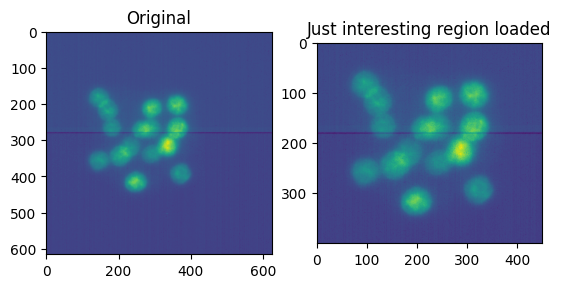

In [2]:
name_file = "0.tif" #Set

file_reader = sitk.ImageFileReader()
file_reader.SetFileName(name_file)
file_reader.ReadImageInformation() #Read infor without uploading file

#Set lims
xlims = (50,500)
ylims = (100,500)
zlims = (0,file_reader.GetSize()[2])

# read the image information without reading the bulk data, compute ROI start and size and read it.
start_index = (xlims[0],ylims[0],zlims[0])
extract_size = (xlims[1]-xlims[0],ylims[1]-ylims[0],zlims[1]-zlims[0])
file_reader.SetExtractIndex(start_index)
file_reader.SetExtractSize(extract_size)
file_reader.SetOutputPixelType(sitk.sitkFloat32)

fig,ax = plt.subplots(1,2)

ax[0].imshow(sitk.GetArrayFromImage(sitk.ReadImage(name_file)).sum(axis=0))
ax[0].set_title("Original")
ax[1].imshow(sitk.GetArrayFromImage(file_reader.Execute()).sum(axis=0))
ax[1].set_title("Just interesting region loaded")

Load image and set the appropiate spacing

In [3]:
#Load the box region
image_3D = file_reader.Execute()
#Set physical space
image_3D.SetSpacing([1,1,4]) #deltaX...
image_3D.SetOrigin((0,0,0)) #origin of the image to rotate, transale etc.

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


Threshold background. This step may not be necessary but when performing rotations translations etc, then there are regions with all zeros. To make it homogeneous, I remove those pixels values to look it nicer.

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


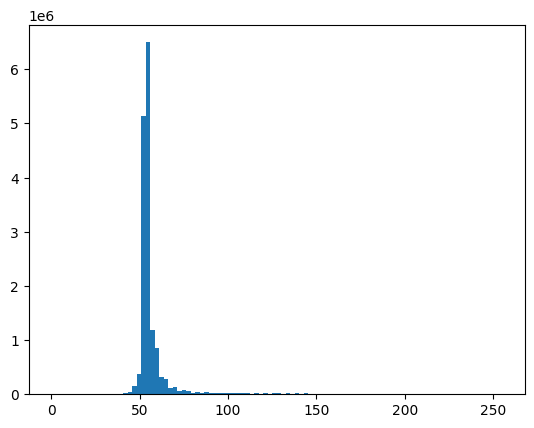

In [4]:
#to choose a threshold of the background noise
plt.hist(sitk.GetArrayFromImage(file_reader.Execute()).flatten(),bins=100)
plt.show()

In [5]:
image_3D_thresholded = file_reader.Execute()
image_3D_thresholded.CopyInformation(image_3D) #use sampe parameters as the original figure

image_3D_thresholded[image_3D<70] = 0

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


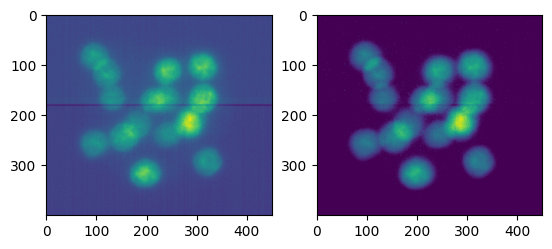

In [6]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(sitk.GetArrayFromImage(image_3D).sum(axis=0))
ax[1].imshow(sitk.GetArrayFromImage(image_3D_thresholded).sum(axis=0))

# Transform

Make a random transformation.

In [9]:
rot_ax= (0,0,1)
rot_angle = 0.1*np.pi
trans = [0,50,0]

#Rotation
transform = sitk.VersorTransform(rot_ax,rot_angle,(image_3D_thresholded.GetHeight()/2,image_3D_thresholded.GetWidth()/2,image_3D_thresholded.GetDepth()/2))
#Translation
transform2 = sitk.TranslationTransform(3,trans)
#Put together
transform_total = sitk.CompositeTransform([transform,transform2])
#Create image
image_3D_transformed = sitk.Resample(image_3D,transform_total)
image_3D_thresholded_transformed = sitk.Resample(image_3D_thresholded,transform_total)

Text(0.5, 1.0, 'thresholded and transformed')

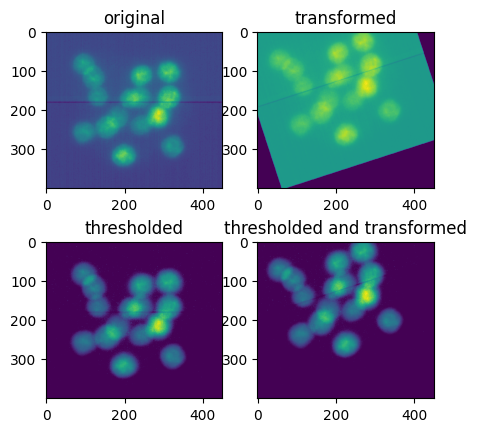

In [10]:
fig,ax = plt.subplots(2,2,figsize=(5,5))

ax[0,0].imshow(sitk.GetArrayFromImage(image_3D).sum(axis=0))
ax[0,0].set_title("original")
ax[0,1].imshow(sitk.GetArrayFromImage(image_3D_transformed).sum(axis=0))
ax[0,1].set_title("transformed")
ax[1,0].imshow(sitk.GetArrayFromImage(image_3D_thresholded).sum(axis=0))
ax[1,0].set_title("thresholded")
ax[1,1].imshow(sitk.GetArrayFromImage(image_3D_thresholded_transformed).sum(axis=0))
ax[1,1].set_title("thresholded and transformed")

Registration

In [11]:
#Set what image is used as a reference and which is transformed
fixed_image = image_3D_thresholded
moving_image = image_3D_thresholded_transformed

In [35]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM) #NONE uses all pints, RANDOM downscales them
registration_method.SetMetricSamplingPercentage(0.01) #Percentage of downscaling

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=0.01,
    numberOfIterations=200,
    convergenceMinimumValue=1e-7,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

#Transform this initializer, 
# (If you do not put it, nothing happens, 
# I have to explore more what it does, I guess this specifies which transformation optimize (Euler3DTransform roations now)
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)
# Don't optimize in-place, we would possibly like to run this cell multiple times. 
registration_method.SetInitialTransform(initial_transform, inPlace=False)

#You can add something to plot during optimization
def f(registration_method):
    print("loss: ",registration_method.GetMetricValue())
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: f(registration_method)
)

# Run the fitting and get the transform
final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print("Final metric value: {0}".format(registration_method.GetMetricValue()))
print(
    "Optimizer's stopping condition, {0}".format(
        registration_method.GetOptimizerStopConditionDescription()
    )
)

loss:  -0.014997724833733154
loss:  -0.015450731259148231
loss:  -0.015442598023691682
loss:  -0.01595670393130476
loss:  -0.016199074324650974
loss:  -0.016468028527930296
loss:  -0.016788824804540445
loss:  -0.017146922404086325
loss:  -0.017187840642546203
loss:  -0.017437924688835676
loss:  -0.017907047376115433
loss:  -0.018582434507907288
loss:  -0.018987118580276303
loss:  -0.01949372700252672
loss:  -0.01992014021217916
loss:  -0.020231470494323413
loss:  -0.021269194711752103
loss:  -0.021924980209270372
loss:  -0.02281485627585093
loss:  -0.023436039647623627
loss:  -0.023947718352608813
loss:  -0.02429583195330762
loss:  -0.025069924314066357
loss:  -0.026402092284206573
loss:  -0.027254232042108778
loss:  -0.02831181152980605
loss:  -0.029483412941378614
loss:  -0.03126780982640028
loss:  -0.033038391237765606
loss:  -0.03515523681142954
loss:  -0.036806060271413865
loss:  -0.03884780546275827
loss:  -0.0407314427708901
loss:  -0.0422939059297498
loss:  -0.04491720090704650

In [38]:
image_3D_corrected = sitk.Resample(image_3D_thresholded_transformed,sitk.CompositeTransform([final_transform]))

Text(0.5, 1.0, 'Corrected')

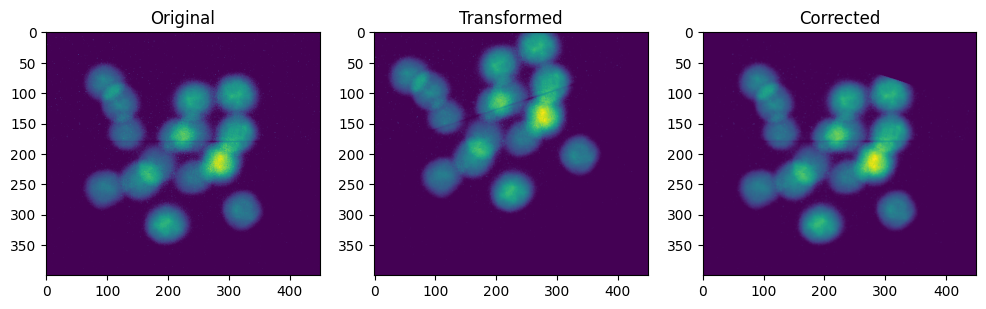

In [39]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].imshow(sitk.GetArrayFromImage(image_3D_thresholded).sum(axis=0))
ax[0].set_title("Original")
ax[1].imshow(sitk.GetArrayFromImage(image_3D_thresholded_transformed).sum(axis=0))
ax[1].set_title("Transformed")
ax[2].imshow(sitk.GetArrayFromImage(image_3D_corrected).sum(axis=0))
ax[2].set_title("Corrected")

In [ ]:
plt.imshow(skimage.io.imread(""))